# Clustering with Affinity Propagation

In [1]:
# Modify sys.path to allow imports of own modules
import os
import sys

BASE_DIR = os.path.join(os.path.abspath(""), "..")
sys.path.insert(0, BASE_DIR)


from clustering.affinity_propagation import affinity_propagation
from data.datasource import load_X_y

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from IPython.display import display
import pandas as pd
from time import time

## Preparing dataset

In [3]:
# Load dataset
X, y, df = load_X_y(os.path.join(BASE_DIR, "data", "SpotifyFeatures.csv"), sample_size=500)

np.random.seed(42)

n_samples, n_dims = X.shape

## Base run
Experimentig with different parameters in [main.py](../main.py) did not show noticeable differences for different parameters. The only tendency was that the following tended to perform better:
- A higher value for damping -> Fewer oscilations
- A higher value for convergence iter -> More iterations with no change in clustering before algorithm stops

In [5]:
# Run algorithm with chosen parameters and measure runtime
start_time = time()
base_center_indices, base_labels = affinity_propagation(X, damping=0.7, convergence_iter=20)
base_duration = time() - start_time

As we can see below, this creates a lot more clusters than genres in the data set

In [6]:
print(f"Runtime of algorithm: {base_duration*1000:.1f} ms\n")
print(f"Number of clusters: {len(base_center_indices)}")

Runtime of algorithm: 290260.4 ms

Number of clusters: 279


## Adjusting preferences
In addition to the damping, affinity propagation has the option to provide precomputed (self-)preferences for each point. By decreasing this value, we can reduce the number of clusters as points are more likely to choose points other than themselves as exemplars. In addition, the preference values for selected points can be set to a higher value to bias the clustering towards choosing them as exemplars.


In [7]:
from clustering.affinity_propagation import compute_similarity

### 1. Set preferences to minimum similarity
The most simple adaptation is to set the preferences to the minimum value of the similarity matrix

In [8]:
S = compute_similarity(X)
start_time = time()
min_center_indices, min_labels = affinity_propagation(X, damping=0.7, 
                                                      convergence_iter=20, 
                                                      preferences=np.full(shape=y.shape[0], fill_value=np.min(S)))
min_duration = time() - start_time

This reduces the number of clusters noticeably

In [9]:
print(f"Runtime of algorithm: {min_duration*1000:.1f} ms\n")
print(f"Number of clusters: {len(min_center_indices)}")

Runtime of algorithm: 359818.9 ms

Number of clusters: 68


### 2. Benefit first song per genre
To try to bias the clusters towards the genres, we can increase the preference values for one song per genre. As baseline, we will use the first song per genre.

In [10]:
# Set the base preferences to the minimum again and increase the value for one song per genre (as selected by idx)
first_pref = np.full(shape=y.shape[0], fill_value=np.min(S))
_, idx = np.unique(y, return_index=True)
first_pref[idx] = np.median(S)

start_time = time()
first_song_center_indices, first_song_labels = affinity_propagation(X, damping=0.7, 
                                                                    convergence_iter=20, 
                                                                    preferences=first_pref)
first_duration = time() - start_time

In [11]:
print(f"Runtime of algorithm: {first_duration*1000:.1f} ms\n")
print(f"Number of clusters: {len(first_song_center_indices)}")

Runtime of algorithm: 203718.8 ms

Number of clusters: 75


### 3. Select song point per genre
The preferences can be tried to be aligned further with the genres by selecting the song per genre that is most similar to other songs from the same genre

In [12]:
unique_genres = np.unique(y)
repr_idx = []

for genre in unique_genres:
    grouped_songs = S[y[:,0] == genre]
    sum_similarities = np.sum(grouped_songs, axis=1)
    
    # Find the idx with the max sum of similarities. The second part is added to make the index relative to y
    idx_max_similarity = np.argmax(sum_similarities) + np.min(np.where(y[:,0] == genre))
    repr_idx.append(idx_max_similarity)

print(repr_idx)

[495, 911, 1405, 1655, 2172, 2605, 3383, 3554, 4108, 4512, 5244, 5529, 6191, 6798, 7187, 7631, 8250, 8689, 9071, 9672, 10071, 10634, 11353, 11719, 12122]


In [13]:
repr_pref = np.full(shape=y.shape[0], fill_value=np.min(S))
repr_pref[np.array(repr_idx)] = np.median(S)

In [15]:
start_time = time()
repr_song_center_indices, repr_song_labels = affinity_propagation(X, damping=0.7, 
                                                                  convergence_iter=20, 
                                                                  preferences=repr_pref)
repr_duration = time() - start_time

In [16]:
print(f"Runtime of algorithm: {repr_duration*1000:.1f} ms\n")
print(f"Number of clusters: {len(repr_song_center_indices)}")

Runtime of algorithm: 216352.0 ms

Number of clusters: 78


## Evaluate results

### Rand Index

For the first evaluation, we will use the Rand Index adjusted for chance. It calculates the similarity between two clusterings, here the "correct" one in form of the genres and the predicted one made by the algorithm. 

In [17]:
from sklearn.metrics import adjusted_rand_score

As we can see below, the score improves by reducing the preferences value but scores are quite bad across the board. Interestingly, choosing one song per genre does not improve the score a lot beyond simply using minimum preferences. 

In [19]:
print(f'Baseline score: {adjusted_rand_score(labels_true=y[:,0], labels_pred=base_labels)}')
print(f'Minimum preferences score: {adjusted_rand_score(labels_true=y[:,0], labels_pred=min_labels)}')
print(f'First song score: {adjusted_rand_score(labels_true=y[:,0], labels_pred=first_song_labels)}')
print(f'Representative song score: {adjusted_rand_score(labels_true=y[:,0], labels_pred=repr_song_labels)}')

Baseline score: 0.020830192966268212
Minimum preferences score: 0.05103112650244925
First song score: 0.055217743804668484
Representative song score: 0.054553765916656706


### Contigency Matrix

In [20]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

def plot_sorted_contigency(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels[:, 0], predicted_labels)
    
    # Sort the contigency matrix based on the highest cluster / genre overlap
    row_ind, col_ind = linear_sum_assignment(-contingency)
    contingency_sorted = contingency[row_ind, :]
    
    # Create a dataframe for the plot
    n_genres = df.genre.nunique()
    n_clusters = predicted_labels.max() + 1
    contingency_df = pd.DataFrame(np.transpose(contingency_sorted), 
                                  columns=list(df.genre.unique()), 
                                  index=[f'Cluster {i}' for i in range(n_clusters)])
    
    # Plot the result
    fig, ax = plt.subplots(figsize=(18, 24))
    sn.heatmap(contingency_df, annot=True, ax=ax, fmt=".0f", cmap="Blues")

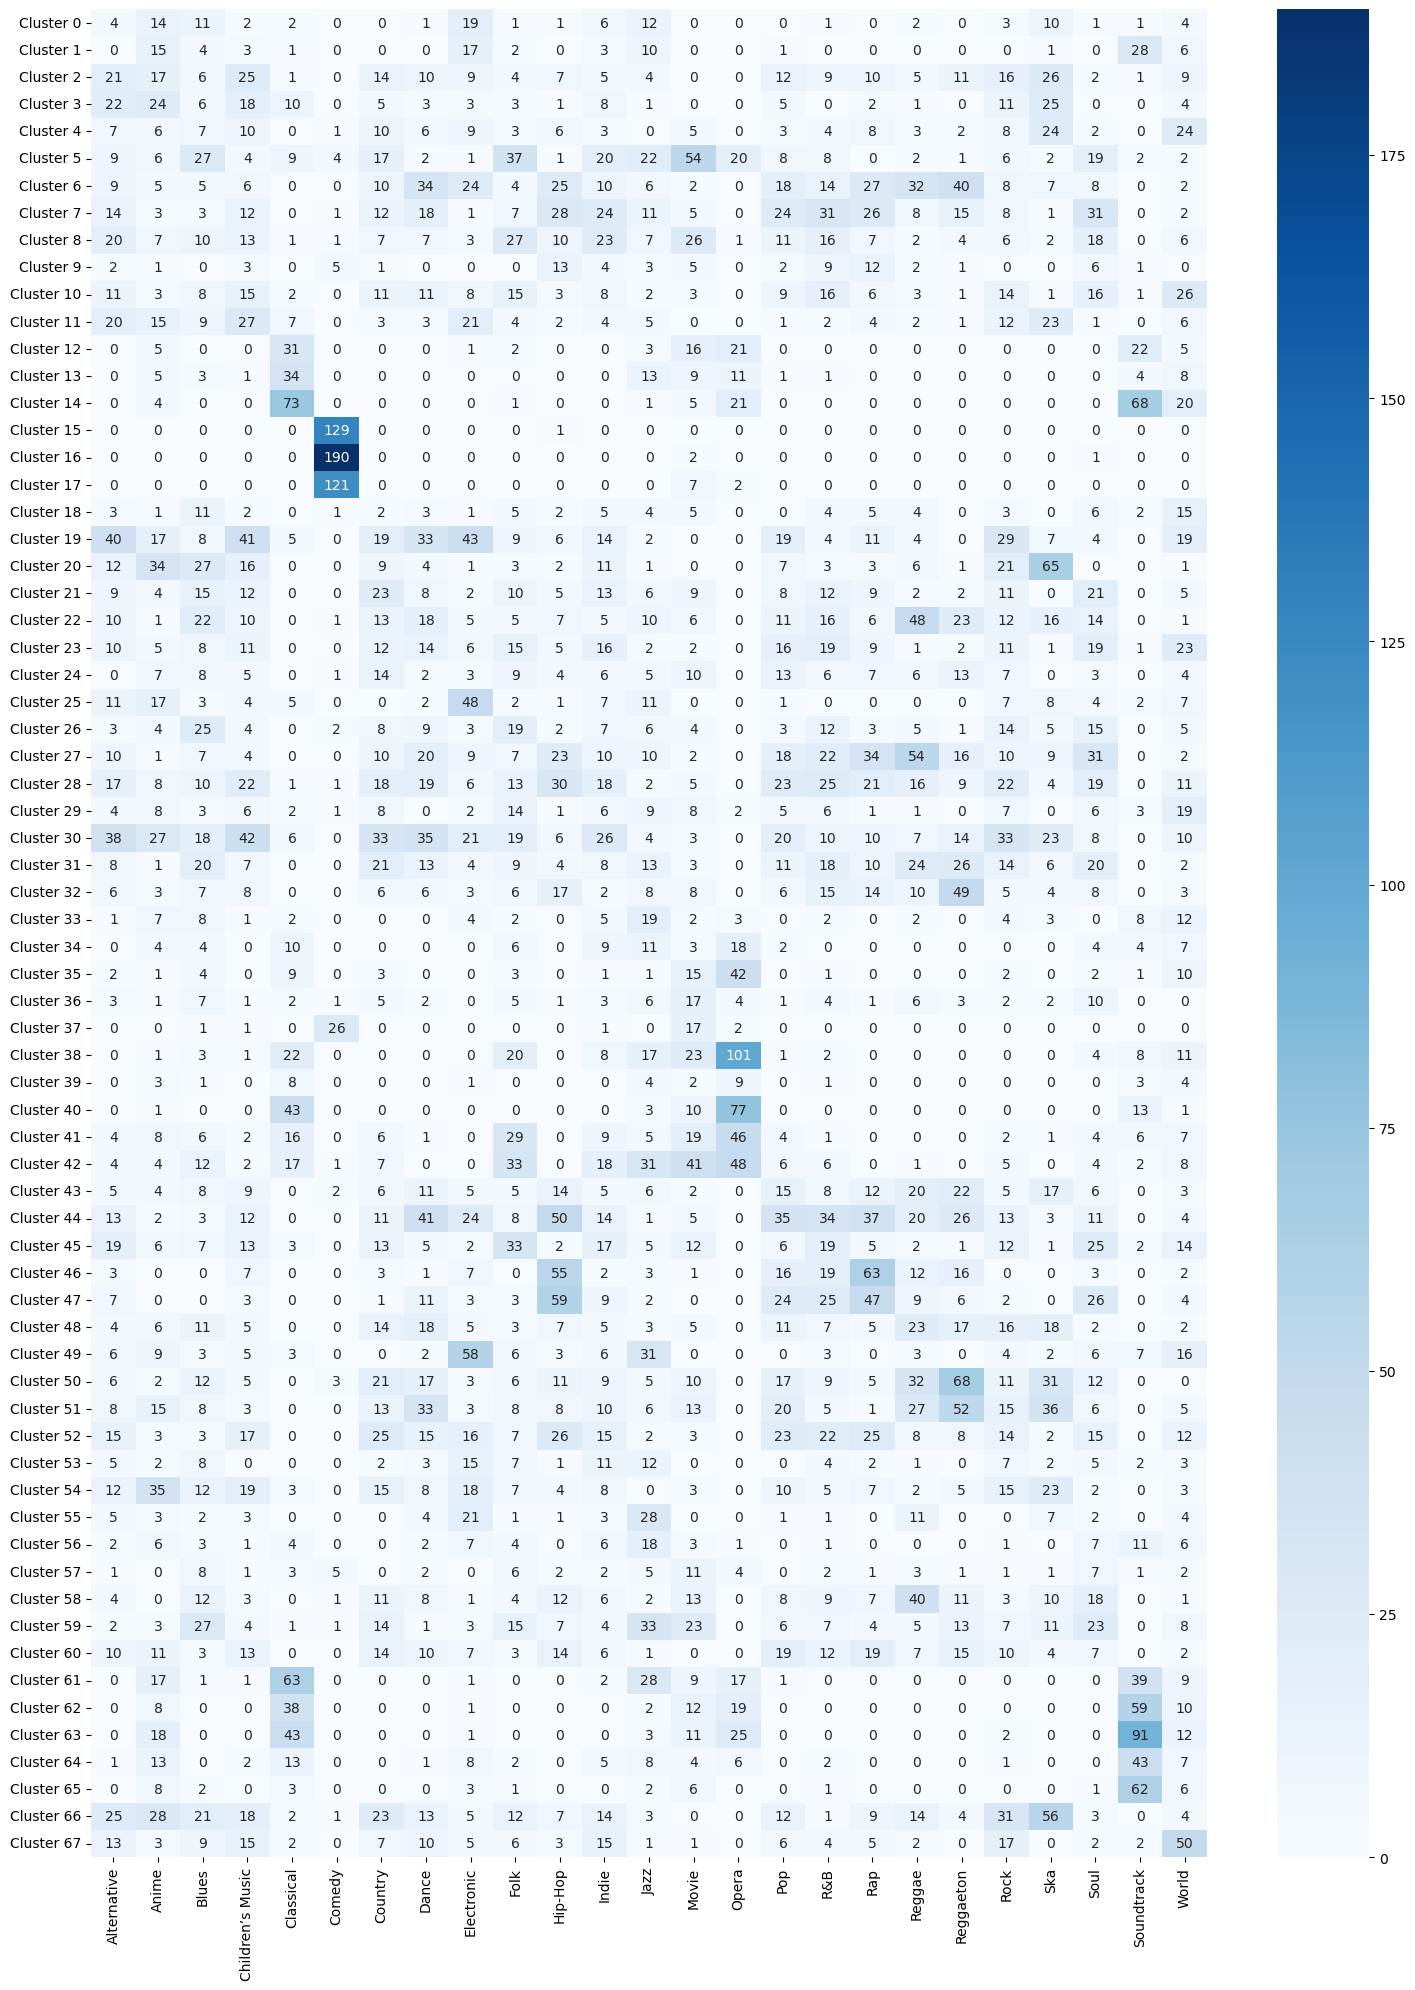

In [21]:
plot_sorted_contigency(y, min_labels)

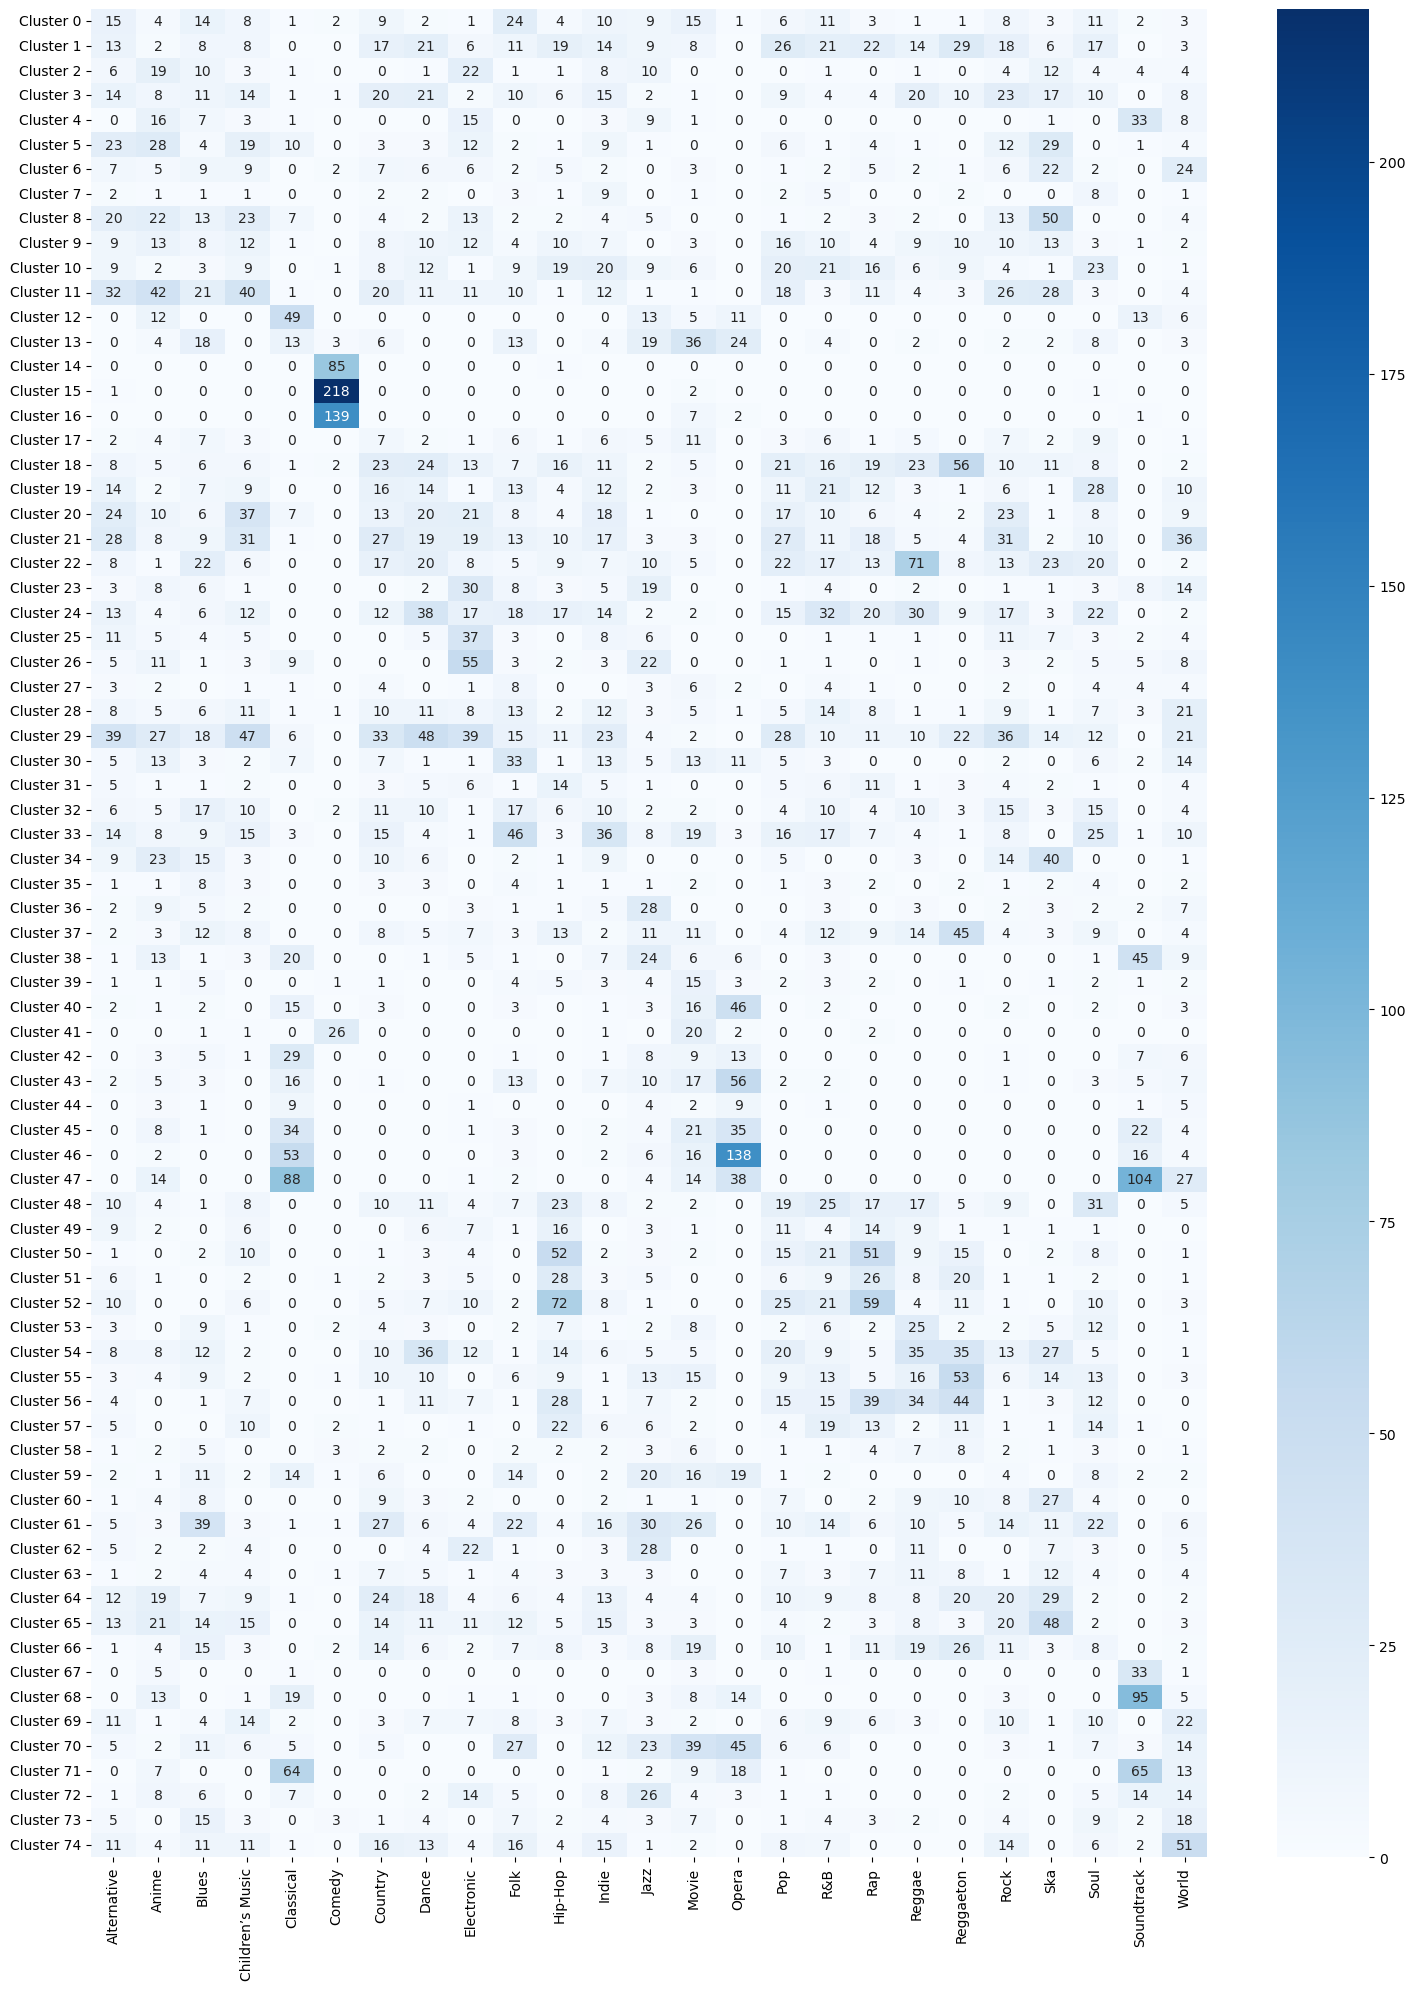

In [22]:
plot_sorted_contigency(y, first_song_labels)

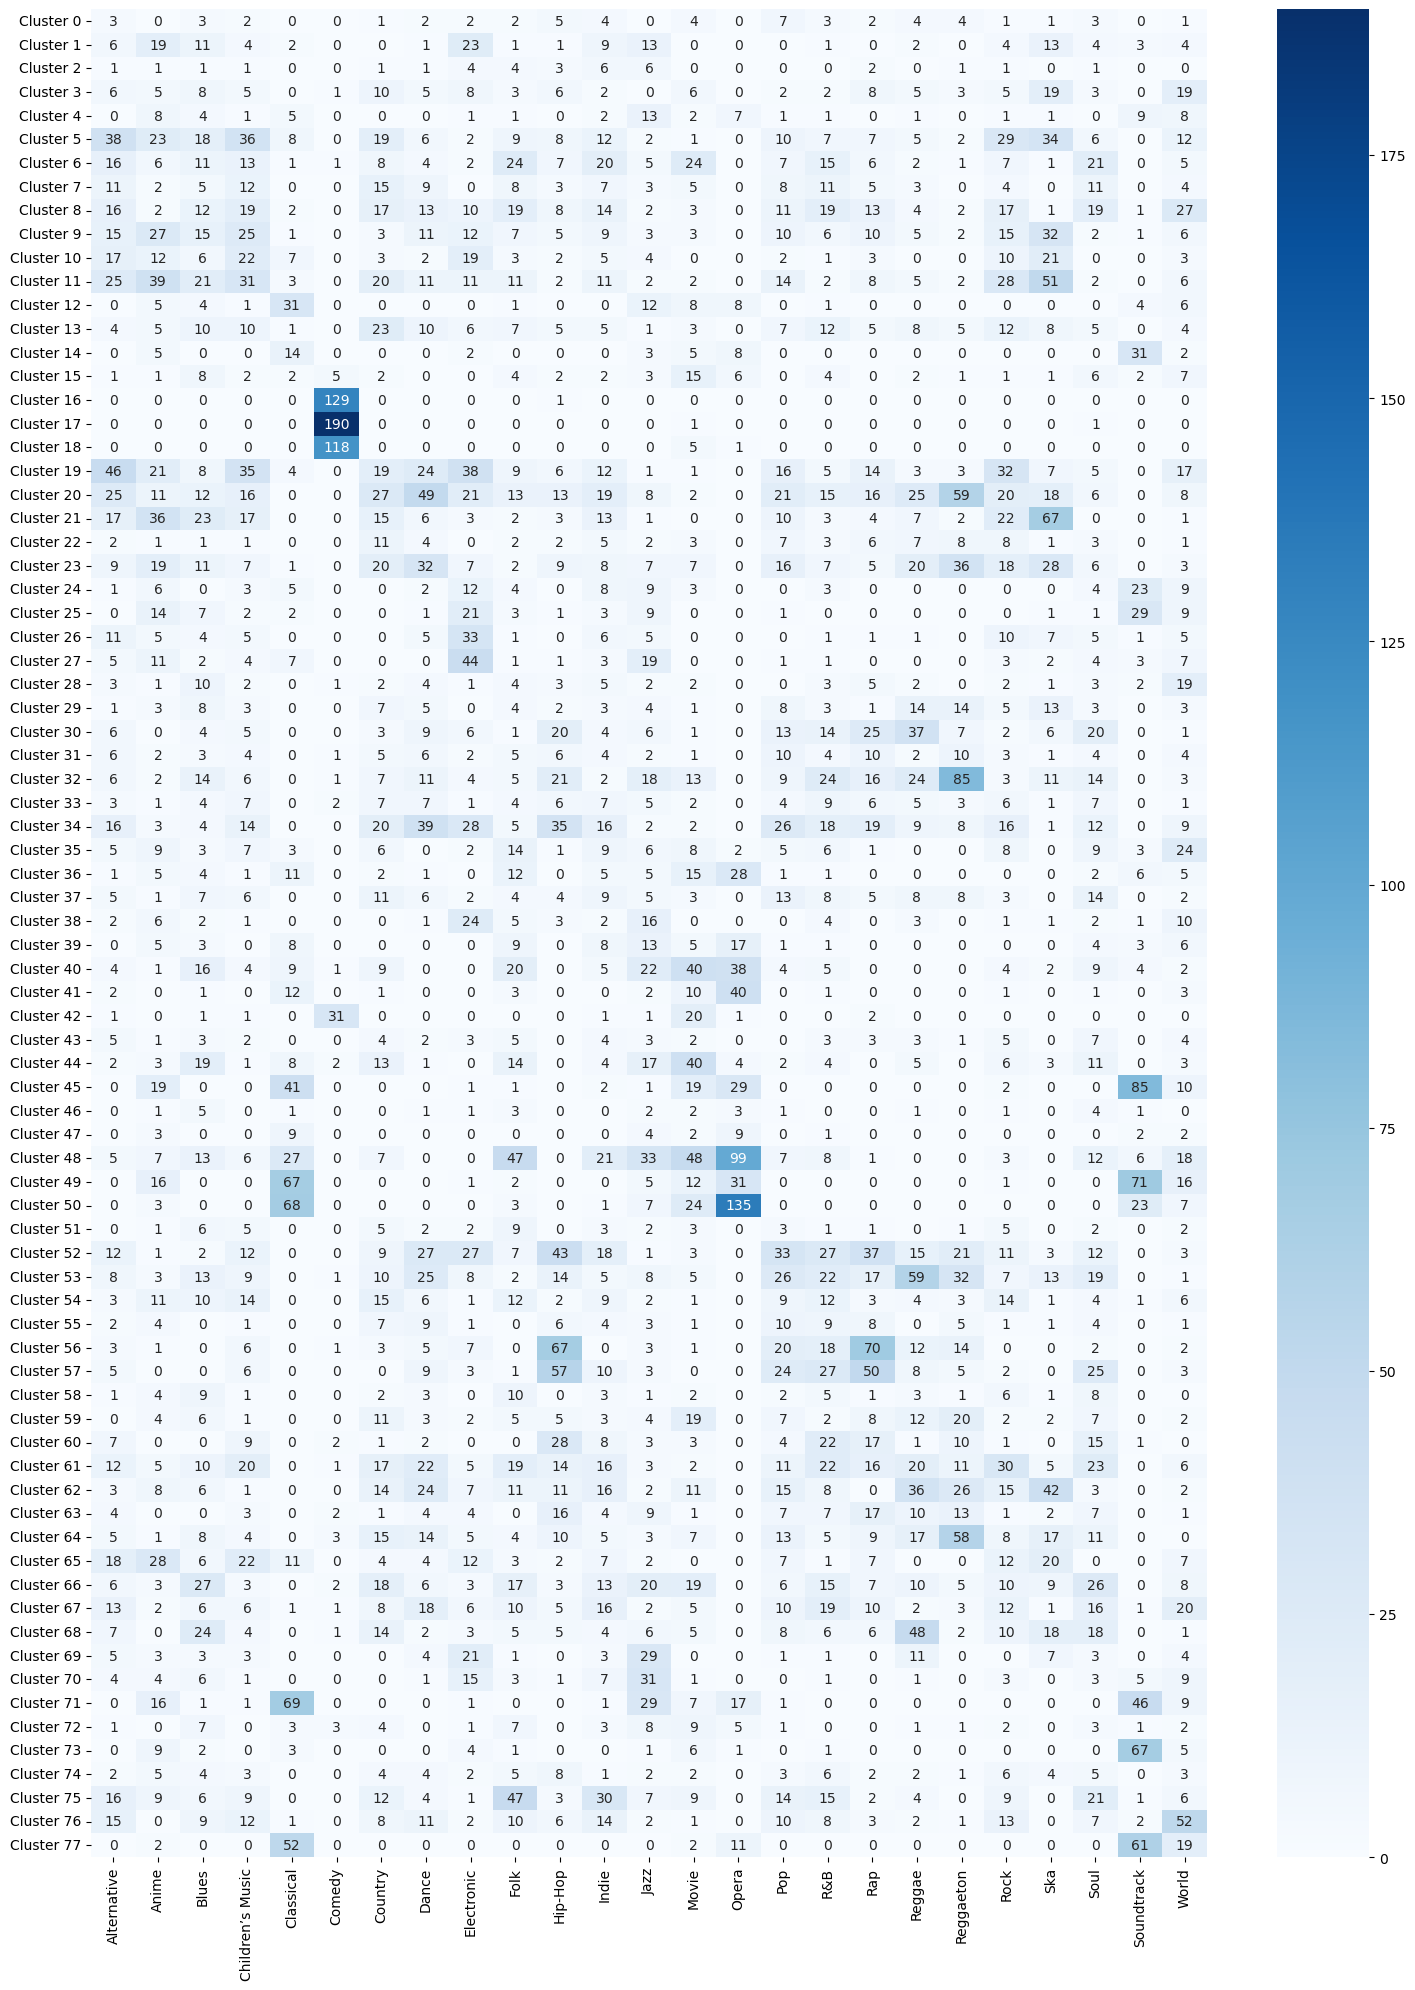

In [23]:
plot_sorted_contigency(y, repr_song_labels)

The contigency matrices show similar results as the Rand Index. Biasing the clustering with higher preference values for songs per genre does not lead to noticeably different clusterings than simply selecting the minimum similarity value as preferences.

Beyond that, we can see two clear tendencies in the clusterings.
- The genre "Comedy" can be separated from the rest (mostly reflected in clusters 16-18)
- The genre "Opera" can be somewhat separated from the rest (Mostly clusters 40 and 50)

Other things to note are:
- Rap and Hip-Hop share some clusters
- Classical and Opera share some clusters as well as Classical and Soundtrack

### Preliminary conclusion
As the strategy of minimum preferences comes with the advantage of not requiring information on the genres (from the target clustering), the following code will use this approach.

## Adapting the minimum preferences approach
Below are two further clustering runs with different values for `damping` (0.5 and 0.9).

In [24]:
start_time = time()
min_center_indices1, min_labels1 = affinity_propagation(X, damping=0.9, 
                                                      convergence_iter=20, 
                                                      preferences=np.full(shape=y.shape[0], fill_value=np.min(S)))
min1_duration = time() - start_time

In [25]:
start_time = time()
min_center_indices2, min_labels2 = affinity_propagation(X, damping=0.5, 
                                                      convergence_iter=20, 
                                                      preferences=np.full(shape=y.shape[0], fill_value=np.min(S)))
min2_duration = time() - start_time

In [26]:
print(f'Higher damping: {adjusted_rand_score(labels_true=y[:,0], labels_pred=min_labels1)}')
print(f'Lower damping: {adjusted_rand_score(labels_true=y[:,0], labels_pred=min_labels2)}')

Higher damping: 0.058275155868710654
Lower damping: 0.05184584219557999


As can be seen above, the performance can be improved further by increasing the damping. The corresponding contigency matrix looks as follows. It can be seen that some, already existing, clusters get a bit more pronounced but overall the genre clustering cannot be reproduced. 

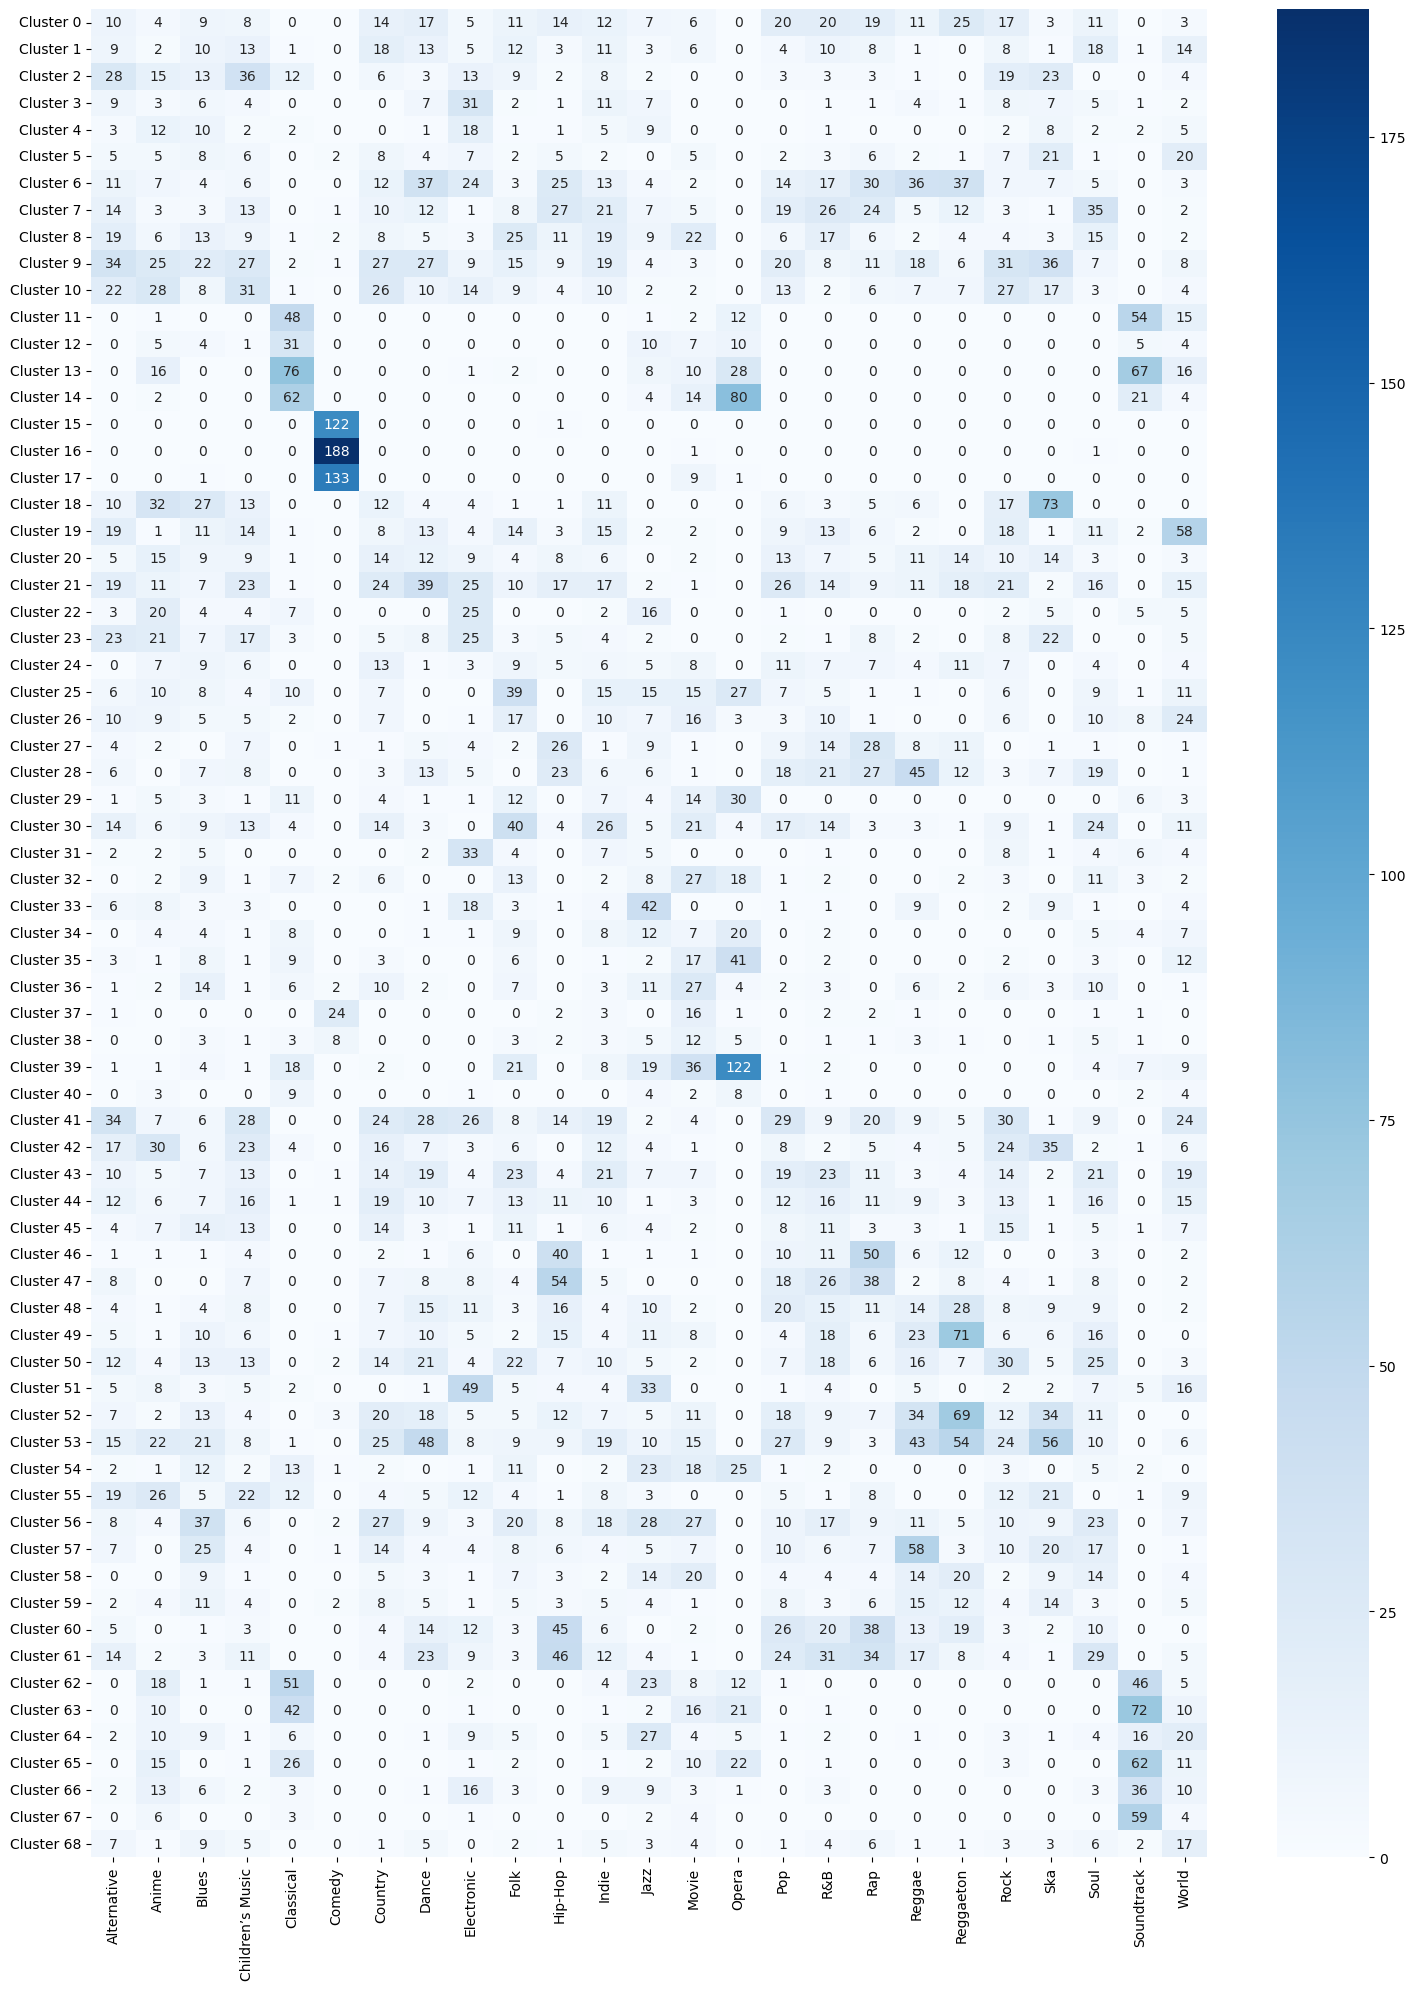

In [27]:
plot_sorted_contigency(y, min_labels2)